In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import f_oneway

In [5]:
#get the data sets
train_df = pd.read_csv('train_set.csv')

In [6]:
#drop the empty column at the beginning
train_df = train_df.drop('Unnamed: 0',axis = 1)

In [7]:
#make the categorical columns into numeric
train_df_encoded = pd.get_dummies(train_df, columns=['language',	'emotion',	'gender'])

In [8]:
#remove unneeded columns and set y column
columns = [column for column in train_df_encoded.columns if 'file_name' != column and 'duration' != column and 'emotion_' not in column ]
pred_column = 'emotion_SAD'


In [9]:
#Separate out the prediction column. Remove the text column (can't standardize text) as well as the coded emotions.
droplist_base= ['file_name']+[column for column in train_df_encoded.columns if 'emotion_' in column]

Xtrain = train_df_encoded.drop(droplist_base, axis=1)
Ytrain = train_df_encoded[pred_column]

#Scale the predictors
scaler = StandardScaler()
Xtrain_scaled_array = scaler.fit_transform(Xtrain)

#Put them back into a dataframe for use
Xtrain_scaled = pd.DataFrame(Xtrain_scaled_array, columns=Xtrain.columns)

KNN

In [10]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(Xtrain_scaled)

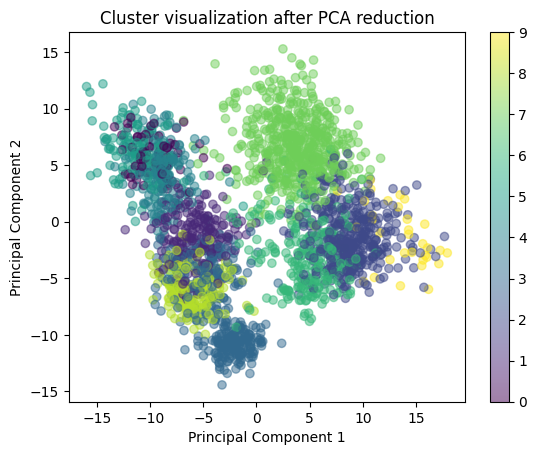

In [11]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(Xtrain_scaled)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
plt.title('Cluster visualization after PCA reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [12]:
train_df['cluster'] = clusters
train_df[train_df['cluster'] == 0][['language', 'emotion', 'gender']].value_counts()
# cluster 0 is mostly English, happy, and female

language  emotion  gender
ENG       HAP      F         73
FRE       HAP      M          1
dtype: int64

In [13]:
train_df[train_df['cluster'] == 3][['gender']].value_counts()
# cluster 1 is mostly English, not sad, male

gender
M         357
dtype: int64

In [14]:
train_df[train_df['cluster'] == 4][['emotion']].value_counts()
# cluster 4 is mostly female, eng, angry

emotion
ANG        171
HAP          4
SAD          1
dtype: int64

In [15]:
train_df[train_df['cluster'] == 5][['language']].value_counts()
# cluster 3 is mostly female, happy, eng

language
ENG         112
GER           1
dtype: int64

In [16]:
train_df[train_df['cluster'] == 6][['gender']].value_counts()
#eng, sad

gender
F         158
M          79
dtype: int64

In [17]:
train_df[train_df['cluster'] == 7][['emotion']].value_counts()
# german, sad

emotion
ANG        285
HAP        187
SAD         49
dtype: int64

In [18]:

centroids = kmeans.cluster_centers_
distances = np.sqrt(((Xtrain_scaled - centroids[clusters]) ** 2).sum(axis=1))

In [19]:
threshold = np.quantile(distances, 0.95)
anomalies = Xtrain_scaled[distances > threshold]

Hierarchical Clustering

In [35]:
Xtrain_scaled = Xtrain_scaled.drop(['cluster_hierarchy'], axis = 1)

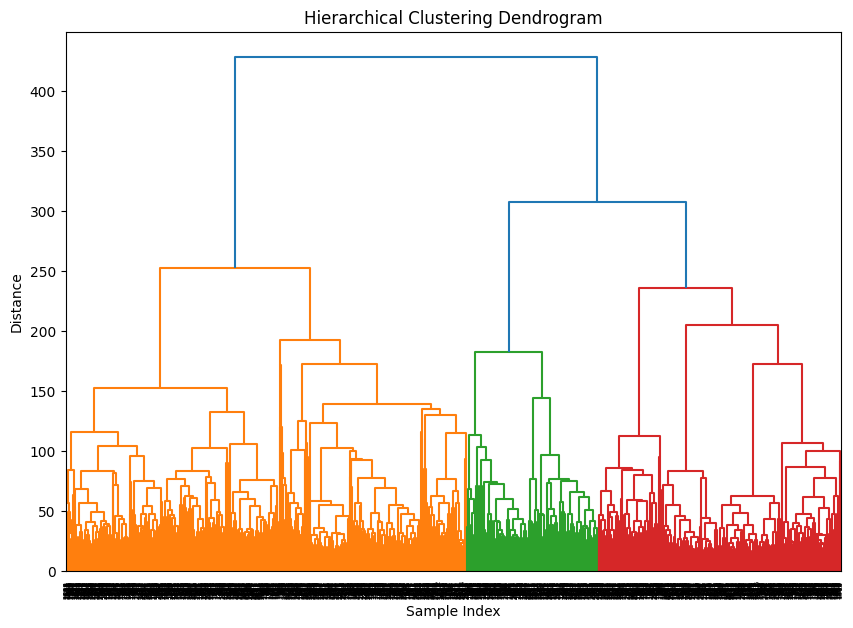

In [36]:
linkage_matrix = linkage(Xtrain_scaled, method='ward', metric='euclidean')

# Step 5: Visualizing the Clustering
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=Xtrain_scaled.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

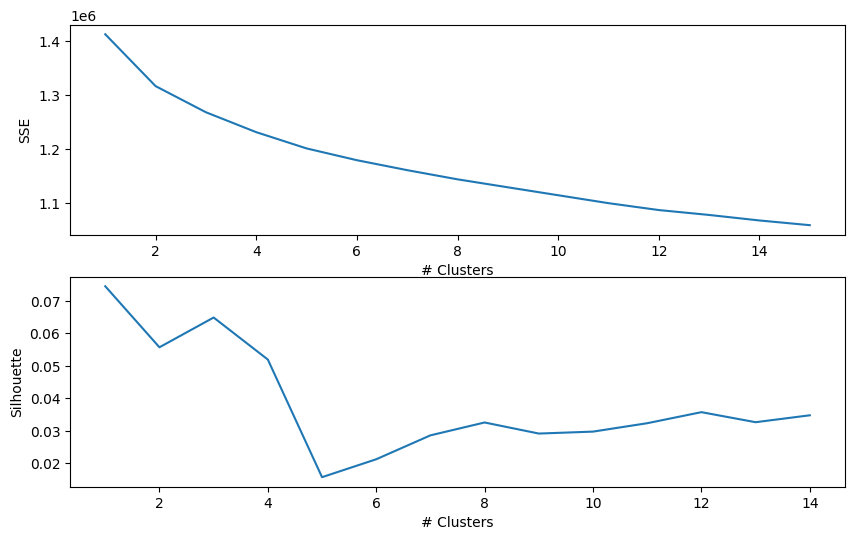

In [37]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import pairwise_distances

def calculate_wcss(data, max_clusters=15):
    inertia = []
    for i in range(1, max_clusters + 1):
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        centroids = np.array([data[clusters == j].mean(axis=0) for j in range(1, i + 1)])
        inertia.append(sum(np.min(pairwise_distances(data, centroids, metric='euclidean'), axis=1) ** 2))
    return inertia

def calculate_silhouette_scores(data, max_clusters=15):
    silhouette_scores = []
    for i in range(2, max_clusters + 1):  # Silhouette score requires at least 2 clusters
        clusters = fcluster(linkage_matrix, i, criterion='maxclust')
        score = silhouette_score(data, clusters, metric='euclidean')
        silhouette_scores.append(score)
    return silhouette_scores

wcss = calculate_wcss(Xtrain_scaled)
silhouette_scores = calculate_silhouette_scores(Xtrain_scaled)
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(wcss) + 1), wcss)
plt.xlabel("# Clusters")
plt.ylabel("SSE")
plt.subplot(2, 1, 2)
plt.plot(range(1, len(silhouette_scores) + 1), silhouette_scores)
plt.xlabel("# Clusters")
plt.ylabel("Silhouette")
plt.show()

In [38]:



# # Initialize variables to store the best max_d and highest silhouette score
# best_max_d = None
# best_silhouette_score = -1

# # Loop through a range of possible max_d values
# for max_d in range(10, 240, 10):  # Adjust range and step as needed
#     clusters = fcluster(linkage_matrix, max_d, criterion='distance')
#     if len(set(clusters)) > 1:  # Ensure there's more than one cluster
#         silhouette_avg = silhouette_score(Xtrain_scaled, clusters)
#         if silhouette_avg > best_silhouette_score:
#             best_silhouette_score = silhouette_avg
#             best_max_d = max_d

# print(f"Best max_d: {best_max_d} with silhouette score: {best_silhouette_score}")

# max_d = best_max_d  # This value depends on your dendrogram
clusters = fcluster(linkage_matrix, 5, criterion='maxclust')

# Add the cluster labels to your dataframe
train_df['cluster_hierarchy'] = clusters
Xtrain_scaled['cluster_hierarchy'] = clusters



/Users/danny/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/danny/Library/Python/3.9/lib/python/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


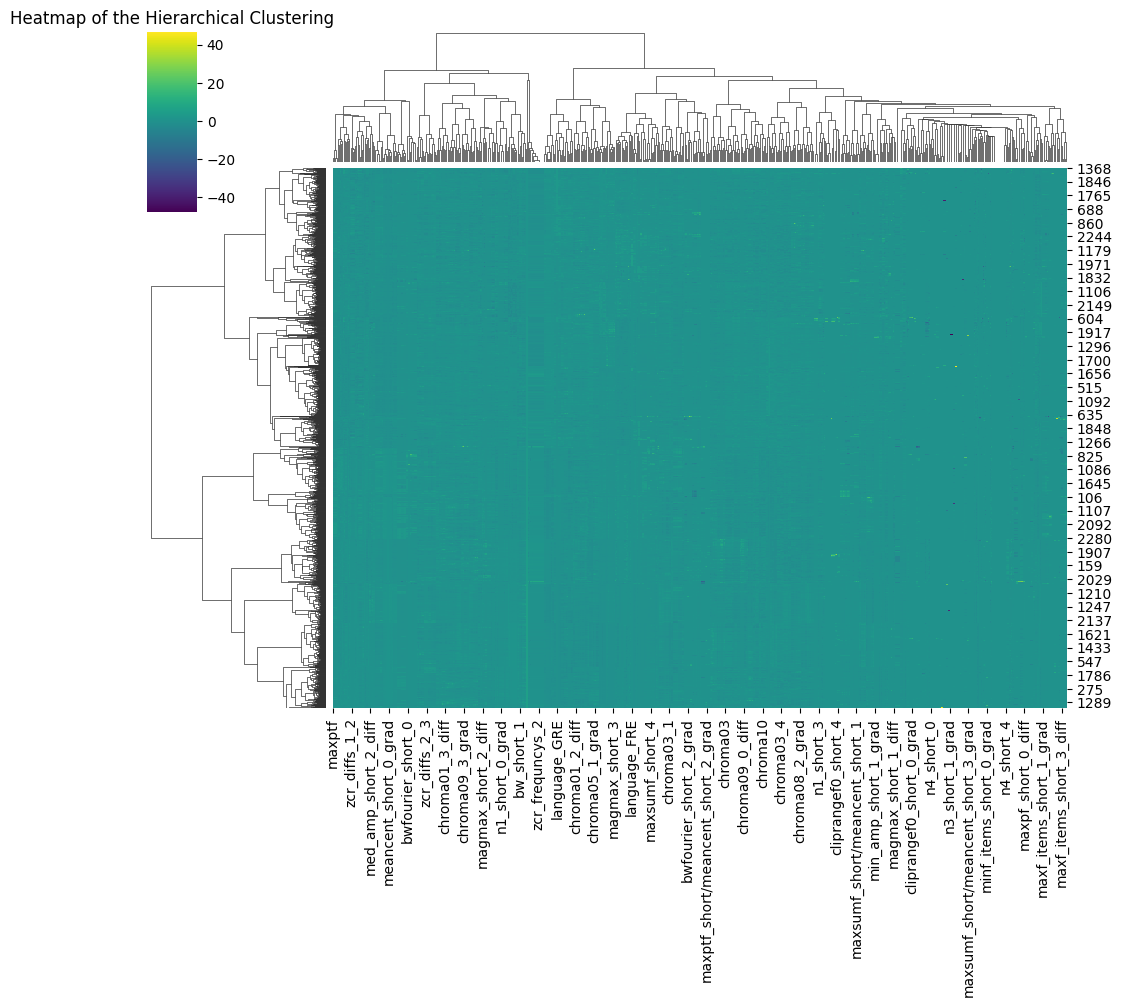

In [39]:
import seaborn as sns

# Compute the distance matrix
distance_matrix = pd.DataFrame(data=linkage_matrix, columns=['index1', 'index2', 'distance', 'num_elements'])

# Create a heatmap
sns.clustermap(Xtrain_scaled, method='ward', metric='euclidean', cmap='viridis', figsize=(10, 10))
plt.title('Heatmap of the Hierarchical Clustering')
plt.show()

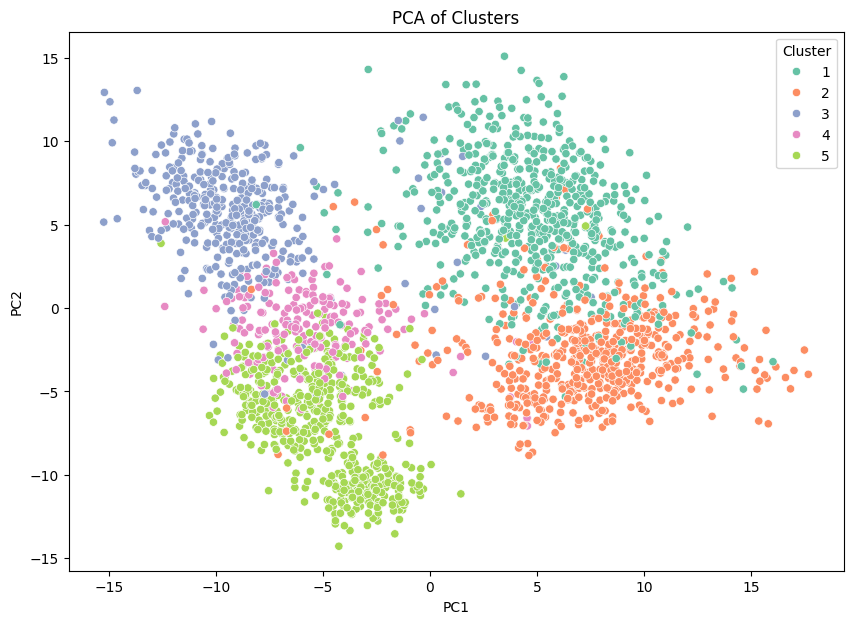

In [40]:
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(Xtrain_scaled)

# Create a DataFrame with PCA results and cluster assignments
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Plot the PCA results
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='Set2')
plt.title('PCA of Clusters')
plt.show()

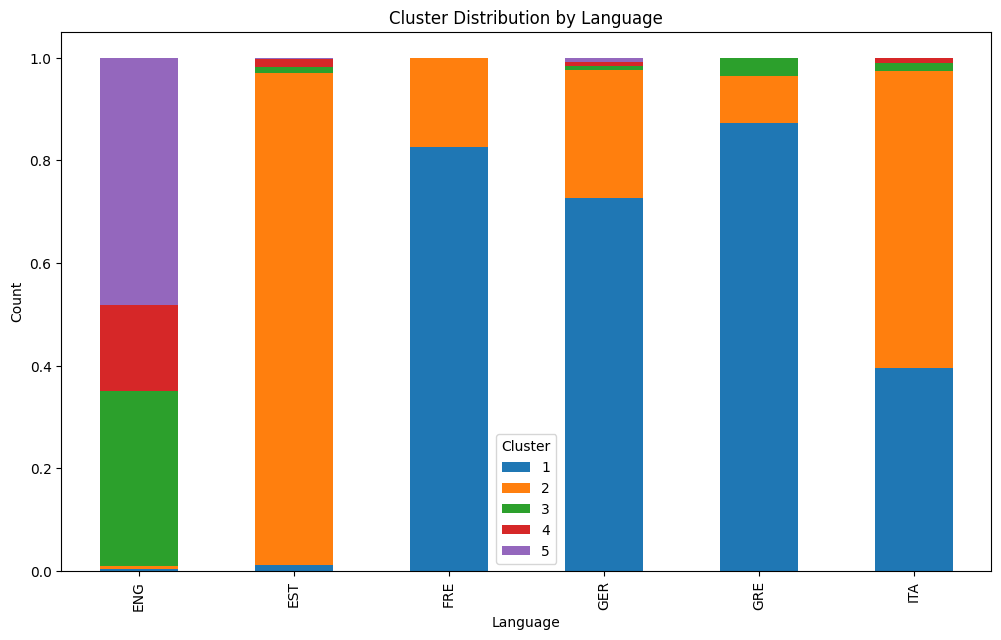

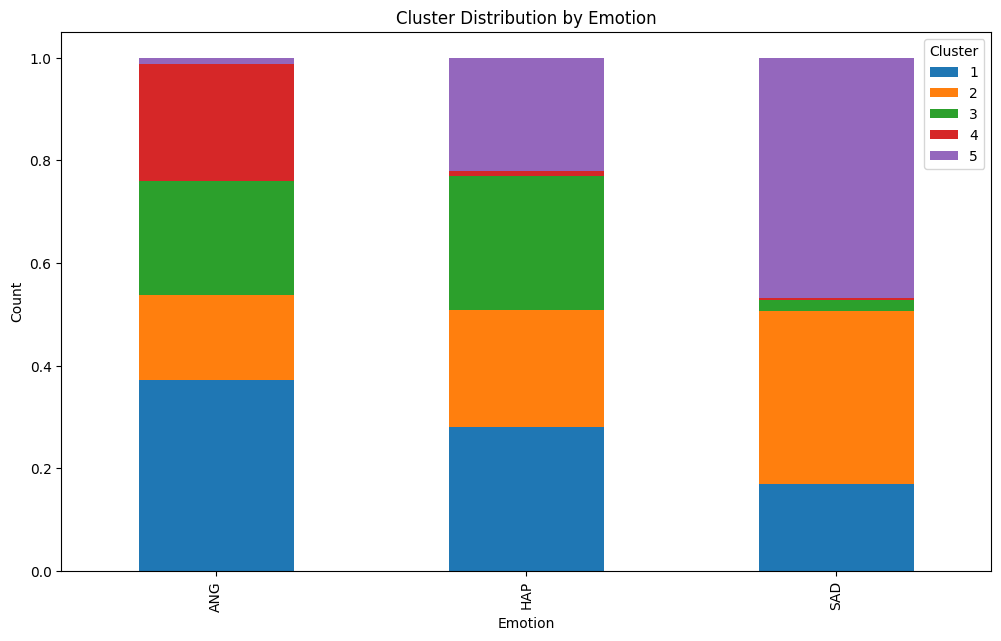

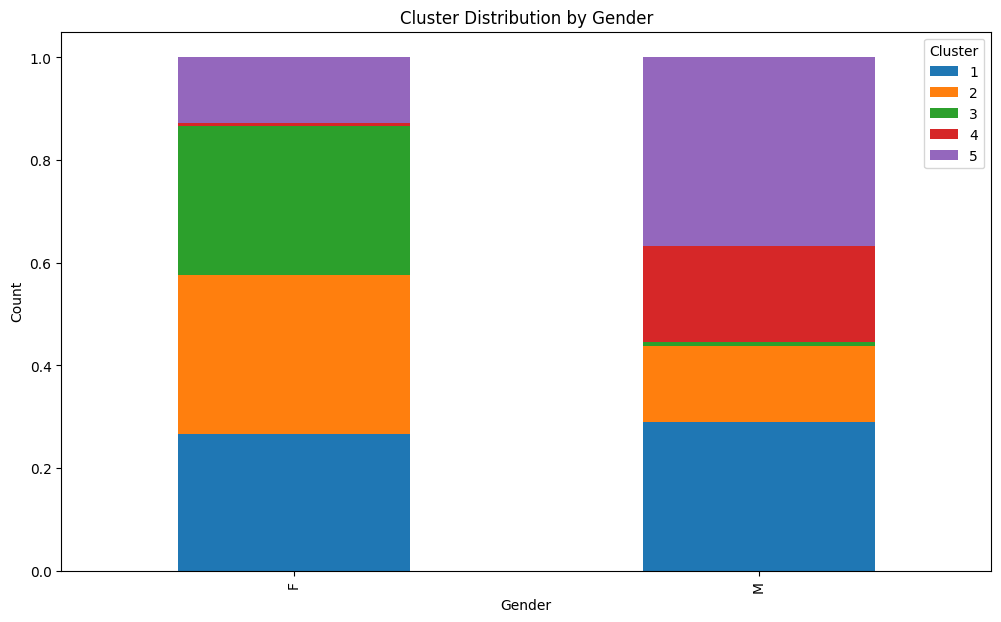

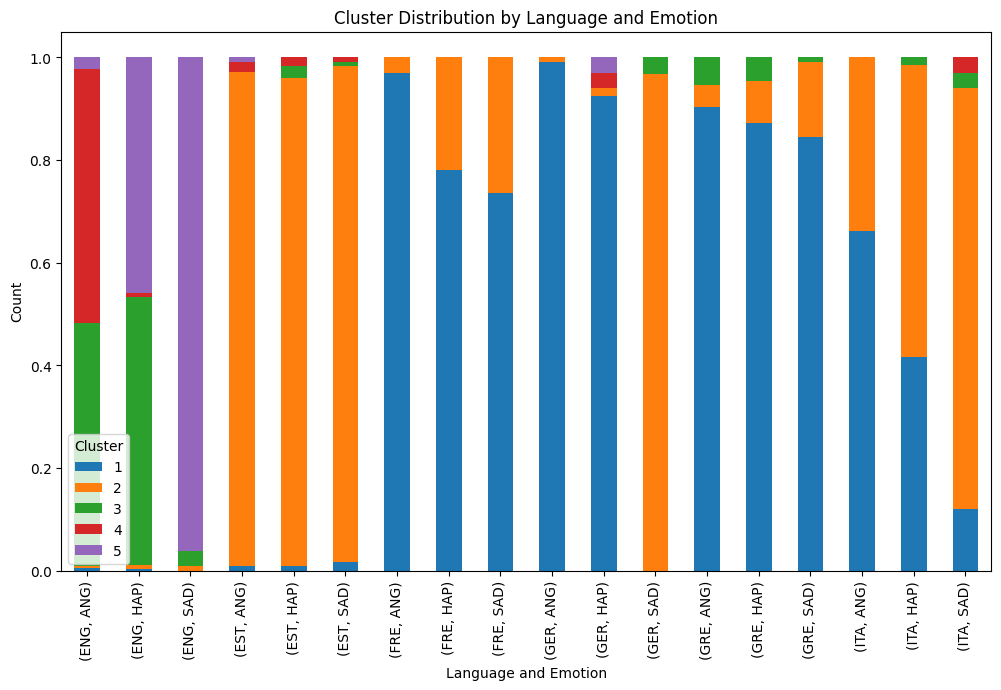

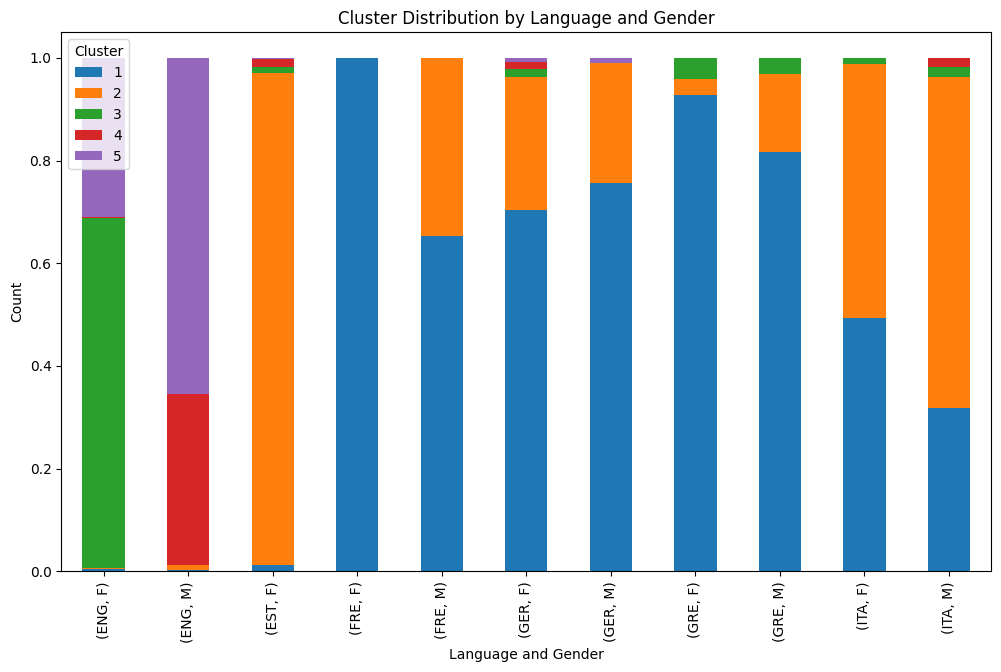

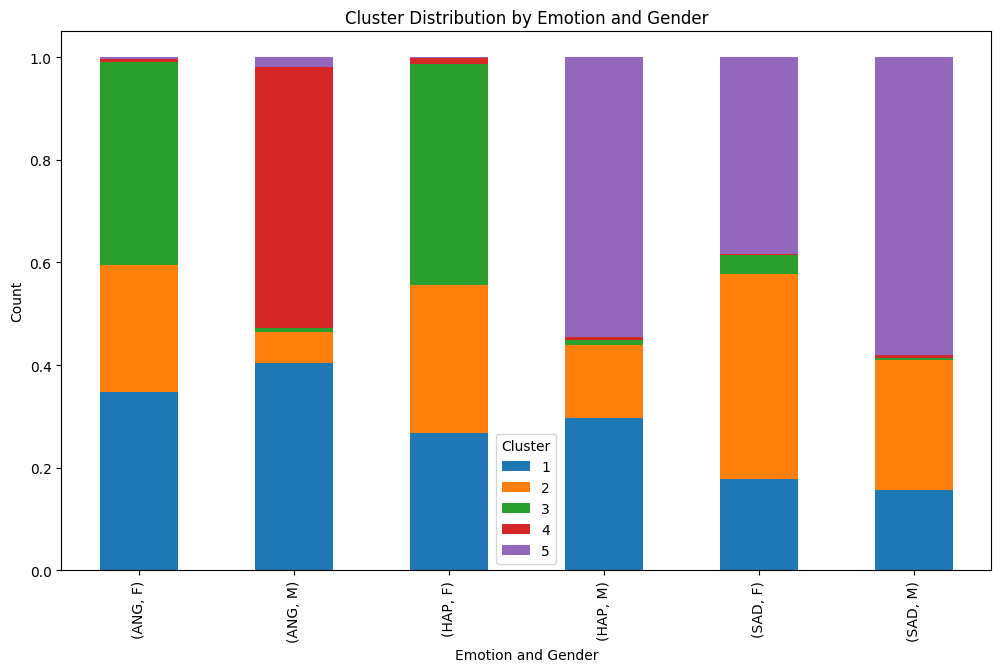

In [41]:
language_cluster_counts = (train_df.groupby(['language', 'cluster_hierarchy']).size() / train_df.groupby(['language']).size()).unstack(fill_value=0)
# Plot bar plot for language vs cluster
language_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

# Repeat for emotion and gender
emotion_cluster_counts = (train_df.groupby(['emotion', 'cluster_hierarchy']).size() / train_df.groupby(['emotion']).size()).unstack(fill_value=0)
emotion_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

gender_cluster_counts = (train_df.groupby(['gender', 'cluster_hierarchy']).size() / train_df.groupby(['gender']).size()).unstack(fill_value=0)
gender_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

language_cluster_counts = (train_df.groupby(['language','emotion', 'cluster_hierarchy']).size() / train_df.groupby(['language', 'emotion']).size()).unstack(fill_value=0)
# Plot bar plot for language vs cluster
language_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Language and Emotion')
plt.xlabel('Language and Emotion')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

language_cluster_counts = (train_df.groupby(['language','gender', 'cluster_hierarchy']).size() / train_df.groupby(['language', 'gender']).size()).unstack(fill_value=0)
language_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Language and Gender')
plt.xlabel('Language and Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

emotion_gender_cluster_counts =  (train_df.groupby(['emotion','gender', 'cluster_hierarchy']).size() / train_df.groupby(['emotion', 'gender']).size()).unstack(fill_value=0)
emotion_gender_cluster_counts.plot(kind='bar', stacked=True, figsize=(12, 7))
plt.title('Cluster Distribution by Emotion and Gender')
plt.xlabel('Emotion and Gender')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.show()

In [42]:


# #Use ANOVA to find the important features
# def anova_by_cluster_apply(df, feature):

#   def calculate_anova(group_data):
#     group_data = group_data[[feature]]  # Select only the feature column
#     data_list = group_data.values.tolist()  # Convert group data to list of lists
#     F, p = f_oneway(*data_list)  # Perform ANOVA on group data
#     return pd.Series({'F': F, 'pval': p}, index=[group_data.index[0]])  
  
#   return df.groupby('cluster_hierarchy').apply(calculate_anova).reset_index()



anova_results = {}
for feature in train_df.drop(['file_name', 'language', 'emotion', 'gender'] , axis = 1).columns[:-2]:  # exclude the 'Cluster' column
    groups = [train_df[train_df['cluster_hierarchy'] == cluster][feature] for cluster in train_df['cluster_hierarchy'].unique()]
    anova_results[feature] = f_oneway(*groups)

#We have so many tests. Do a Bonferroni correction
num_tests = len(anova_results)
p_values = [anova_results[feature].pvalue for feature in anova_results]
corrected_p_values = np.minimum(np.array(p_values) * num_tests, 1.0)  # Bonferroni correction

# Display the results
anova_results_df = pd.DataFrame(anova_results, index=['F-Statistic', 'P-Value']).T
anova_results_df['Bonf Ps'] = corrected_p_values
print(anova_results_df.sort_values(by='Bonf Ps'))

/var/folders/57/tvtsy9l92gnf9zdm586z3fgh0000gp/T/ipykernel_15663/3933624092.py:17: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  anova_results[feature] = f_oneway(*groups)


                                     F-Statistic  P-Value  Bonf Ps
mfccs_std_7                           855.344662      0.0      0.0
mfccs_std_11                          747.410138      0.0      0.0
zcr_means_0                          2397.043134      0.0      0.0
meancent_short_0_grad                1829.149298      0.0      0.0
meancent_short_0_diff                2296.498652      0.0      0.0
...                                          ...      ...      ...
frequncys_zcr_diff                           NaN      NaN      NaN
zcr_frequncys_diffs_from_average0_1          NaN      NaN      NaN
zcr_frequncys_diffs_from_average1_2          NaN      NaN      NaN
zcr_frequncys_diffs_from_average2_3          NaN      NaN      NaN
zcr_frequncys_diffs_from_average3_4          NaN      NaN      NaN

[620 rows x 3 columns]


In [43]:
features = anova_results_df.sort_values(by='Bonf Ps')[0:30].index

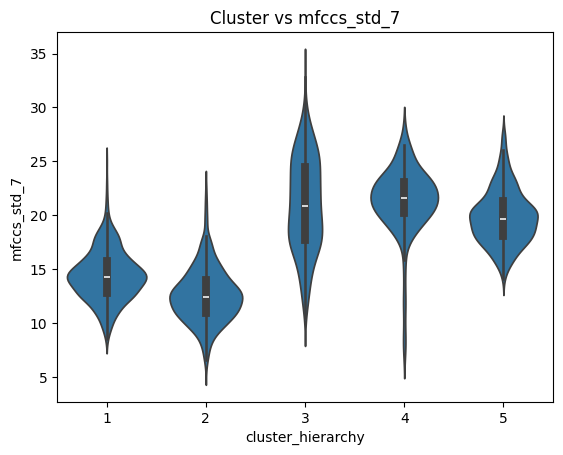

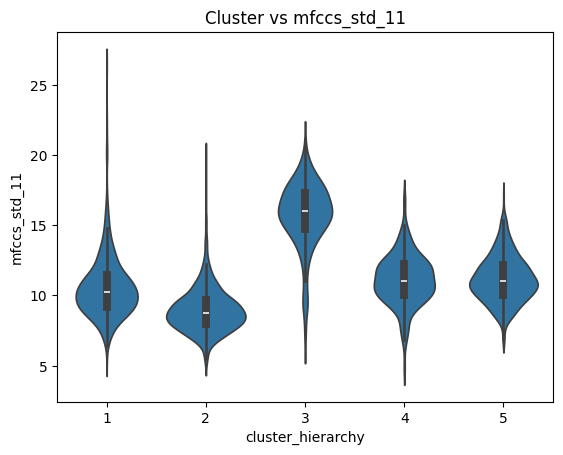

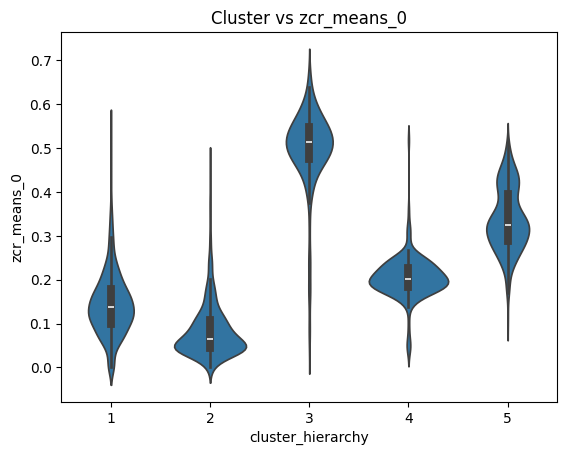

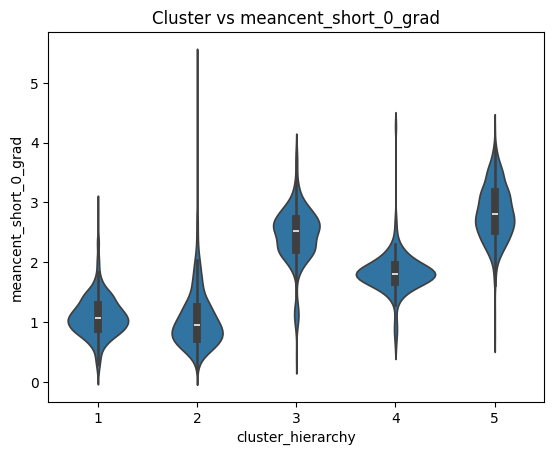

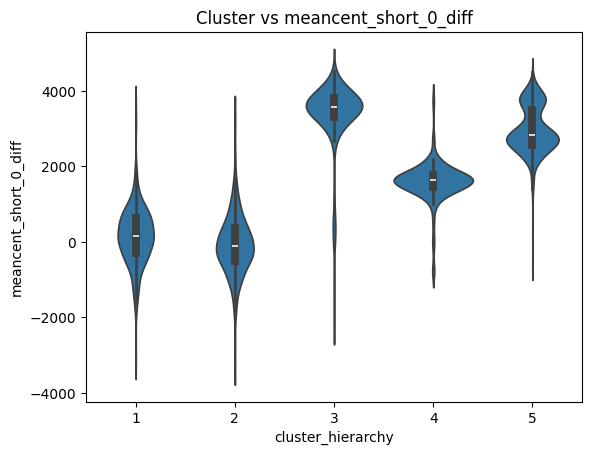

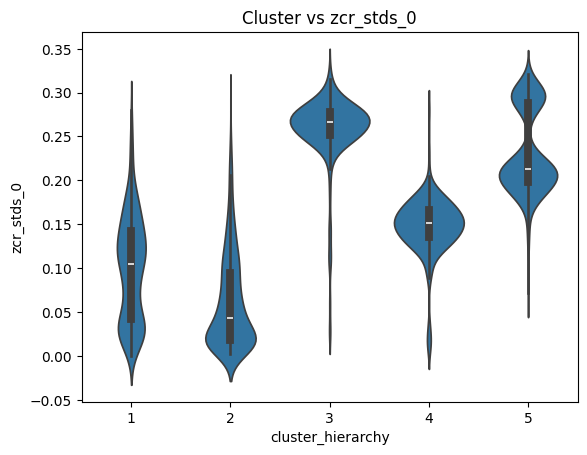

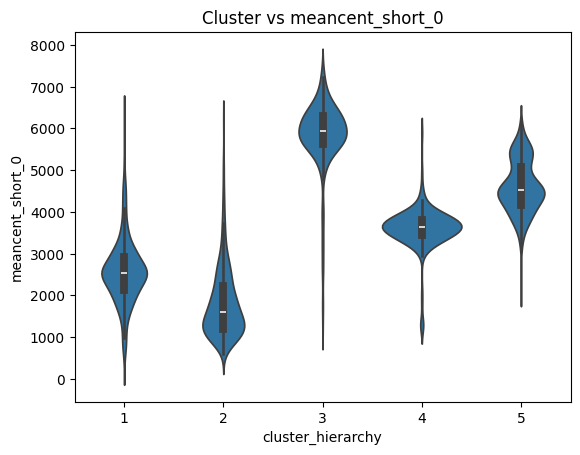

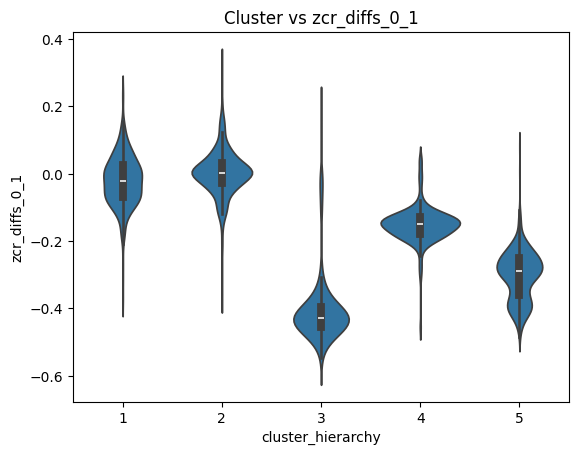

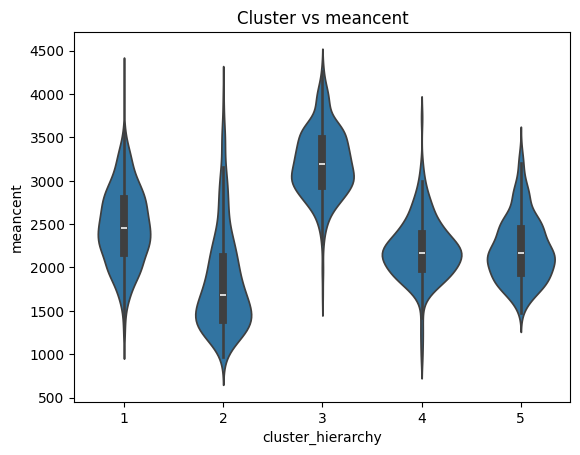

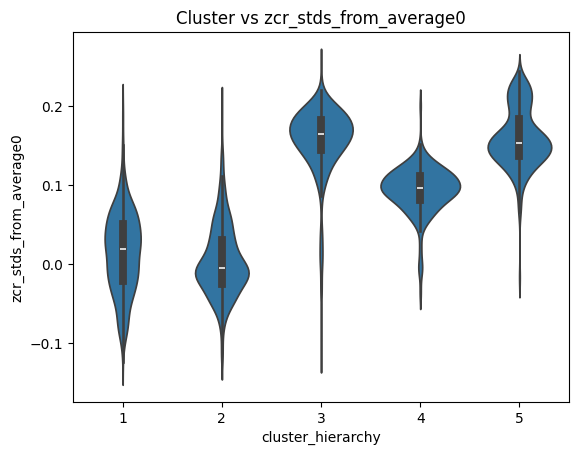

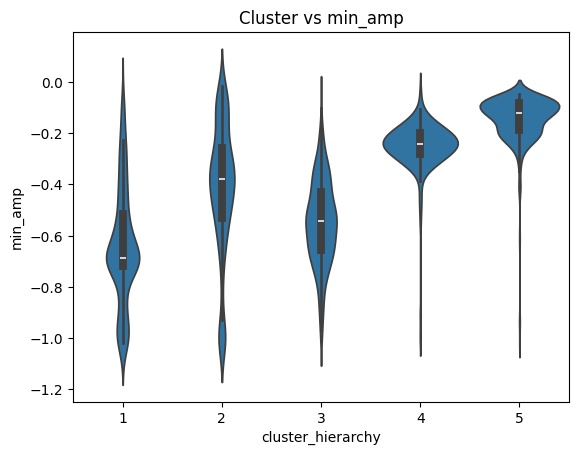

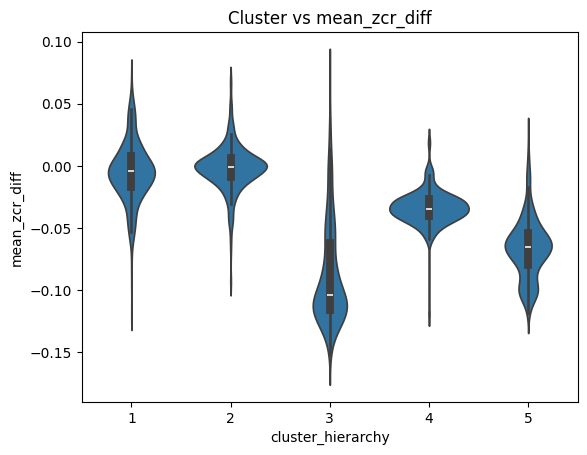

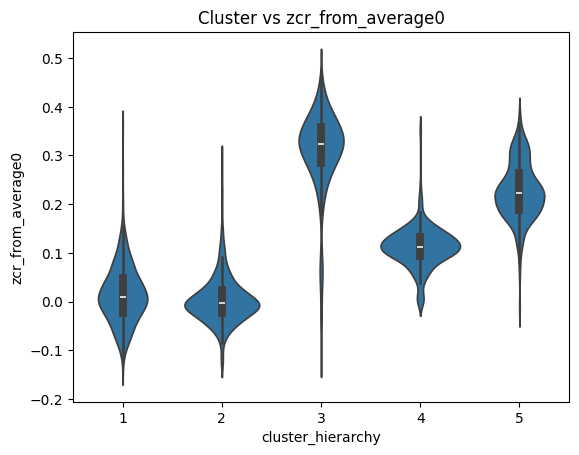

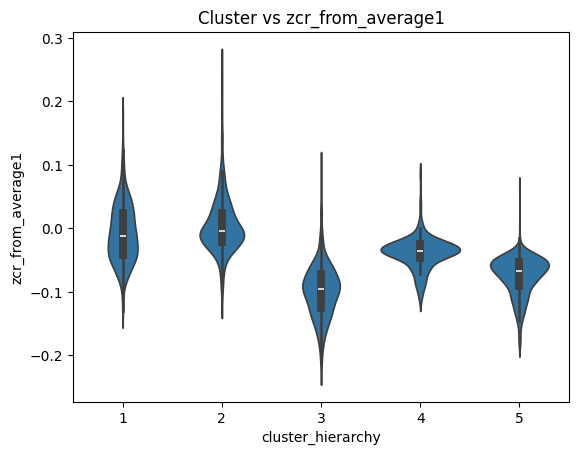

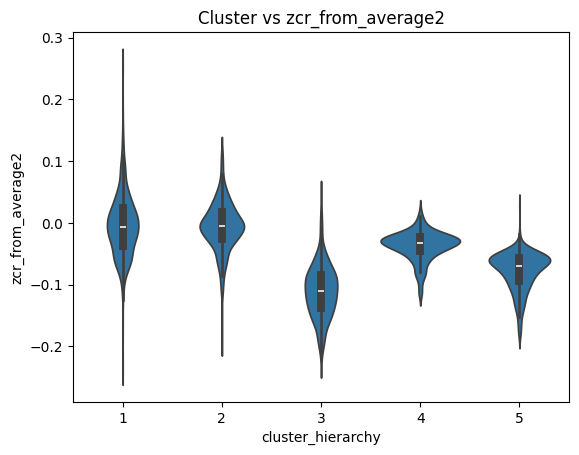

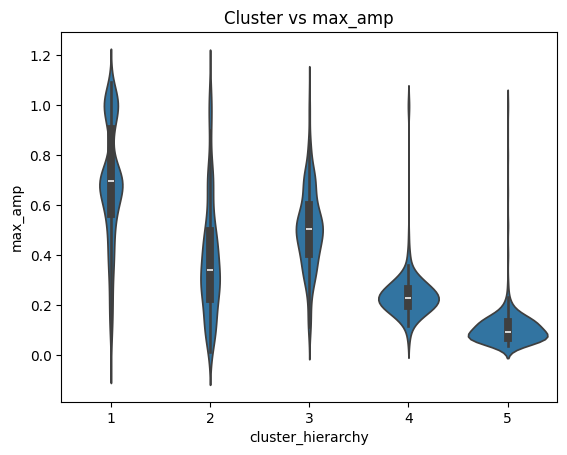

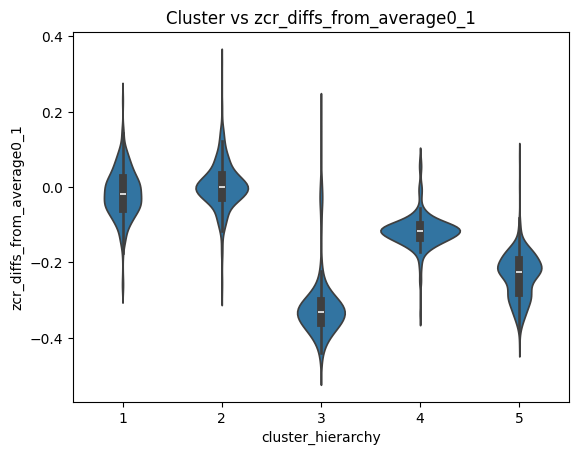

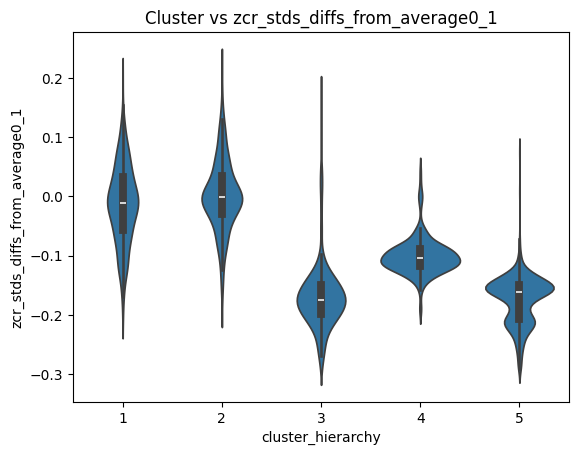

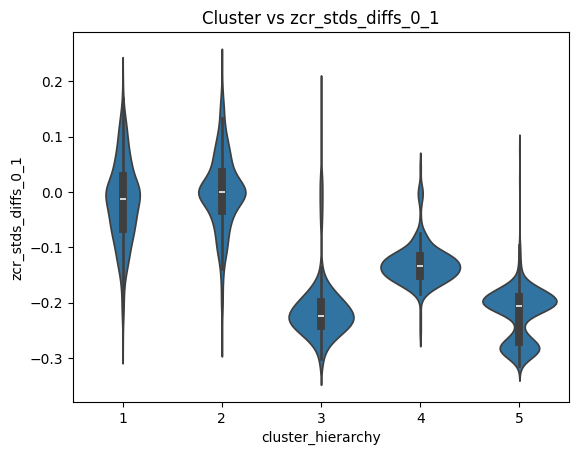

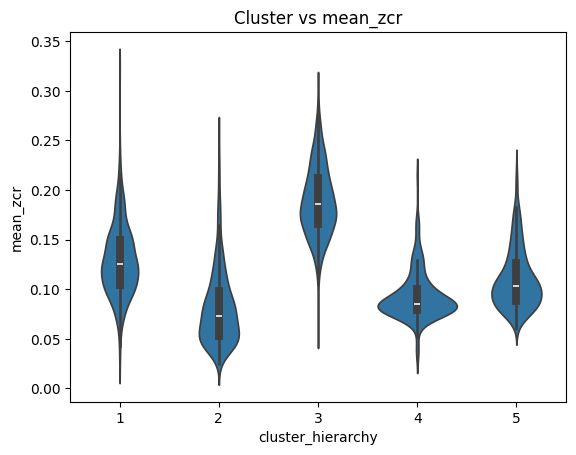

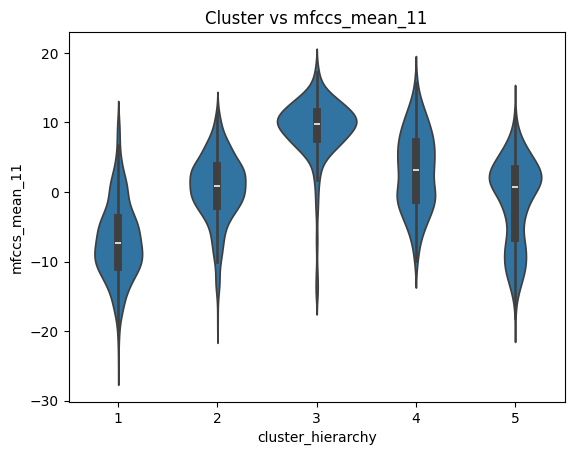

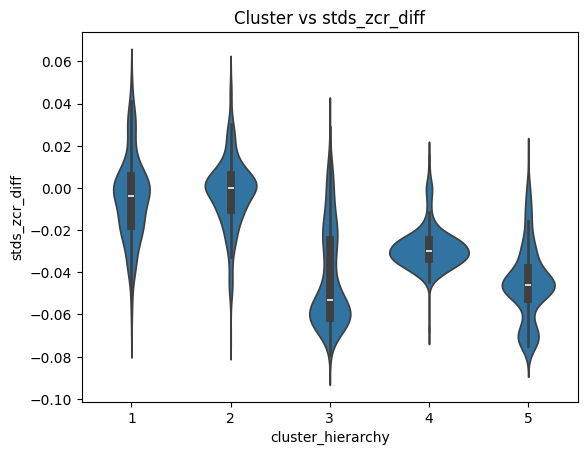

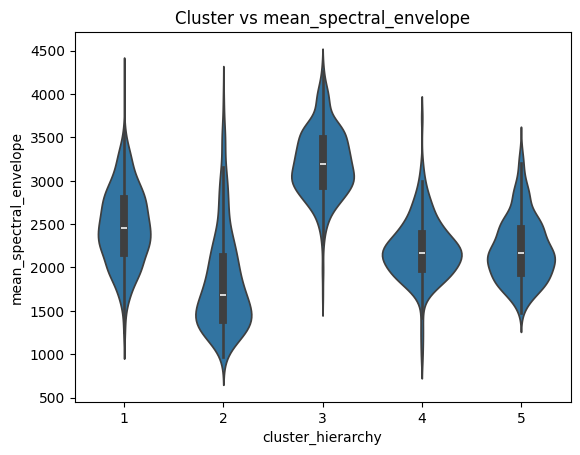

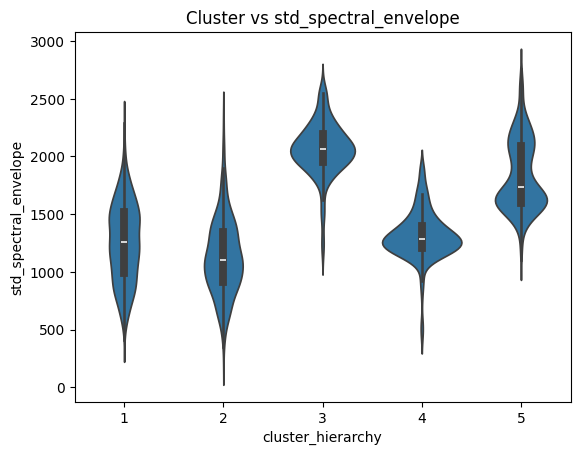

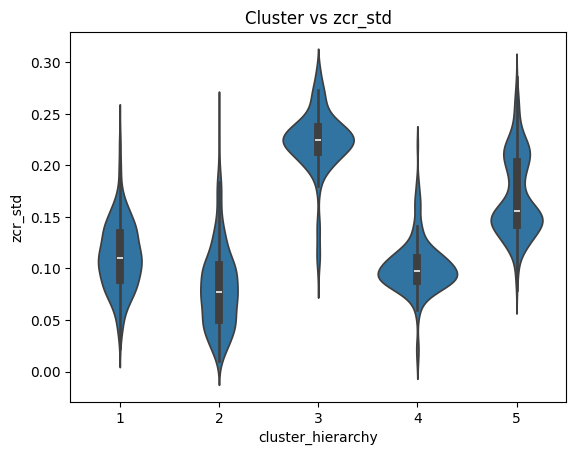

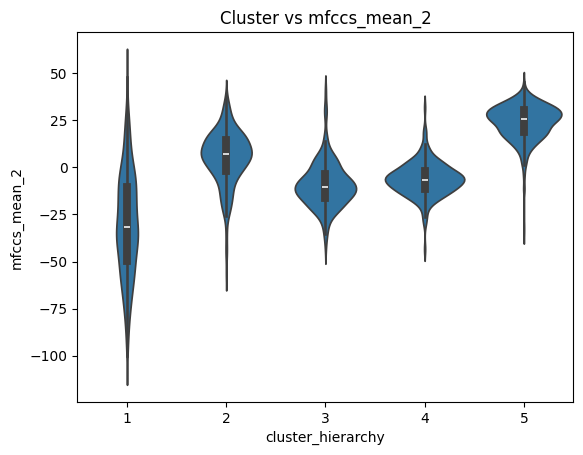

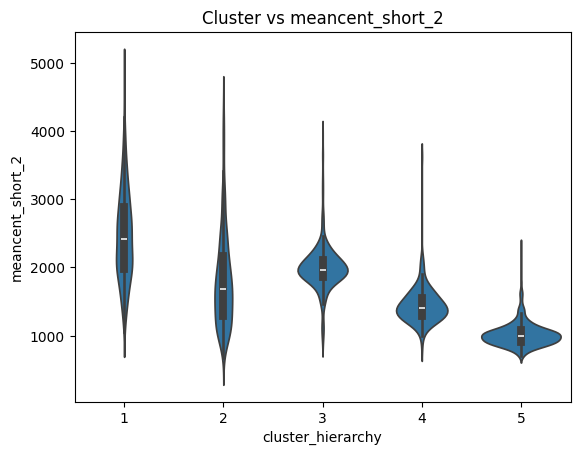

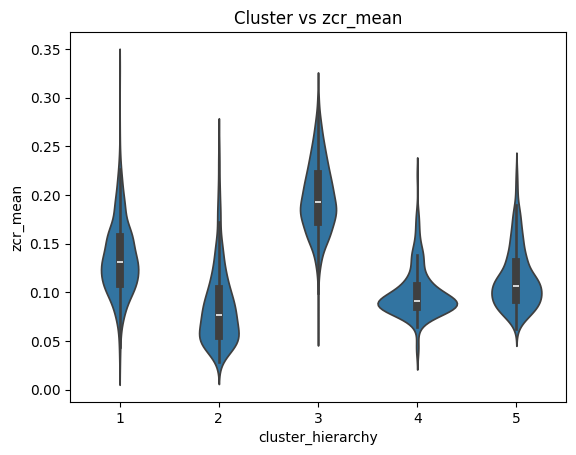

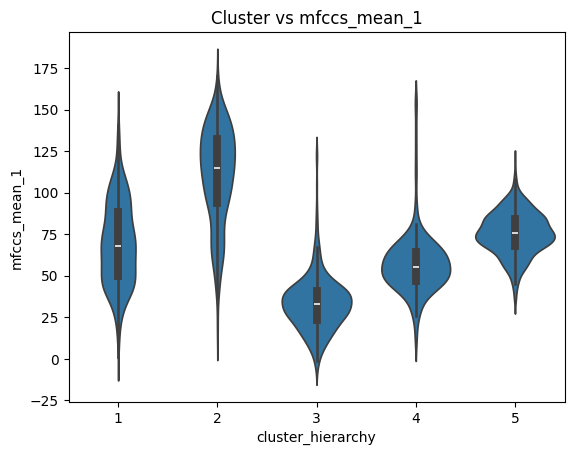

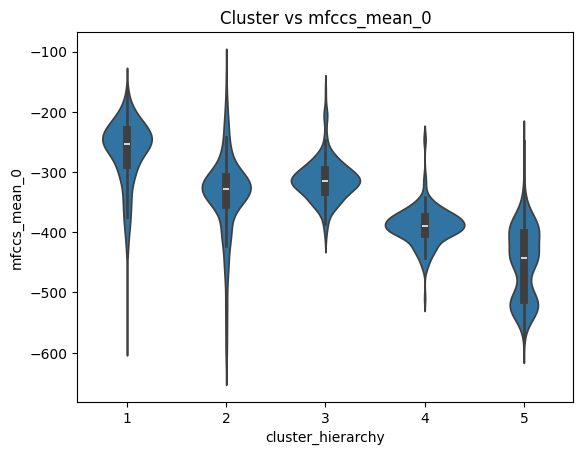

In [29]:
for feature in features:
    sns.violinplot(x='cluster_hierarchy', y=feature, data=train_df)
    plt.title(f'Cluster vs {feature}')
    plt.show()

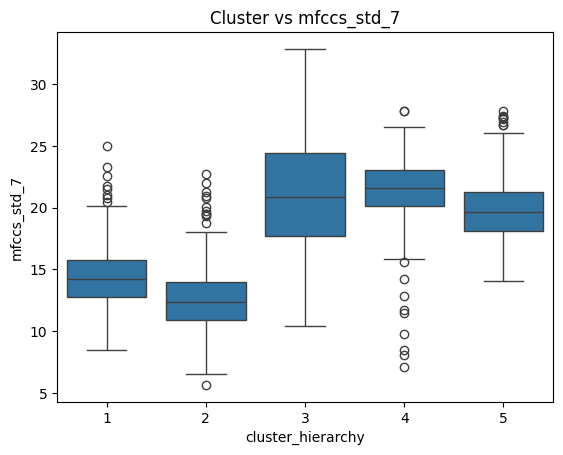

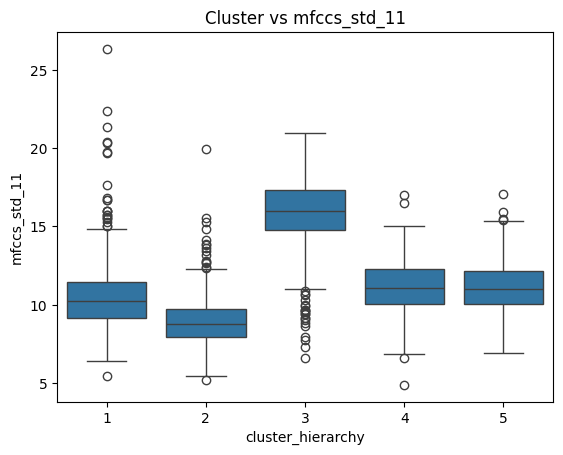

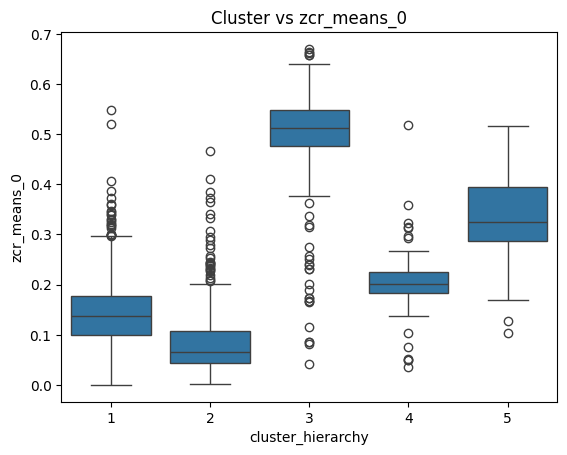

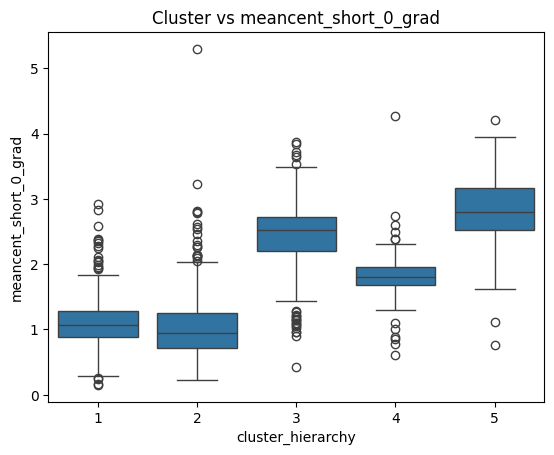

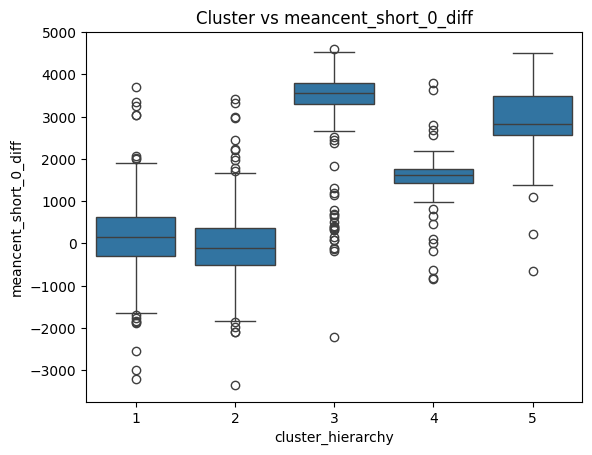

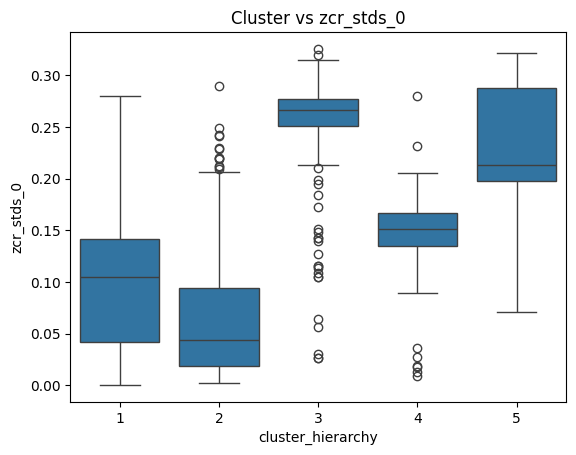

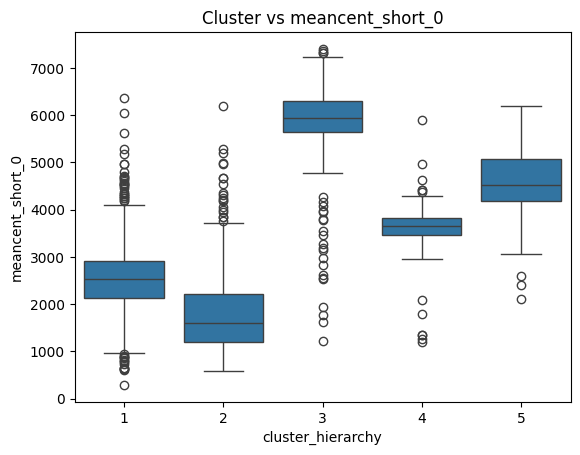

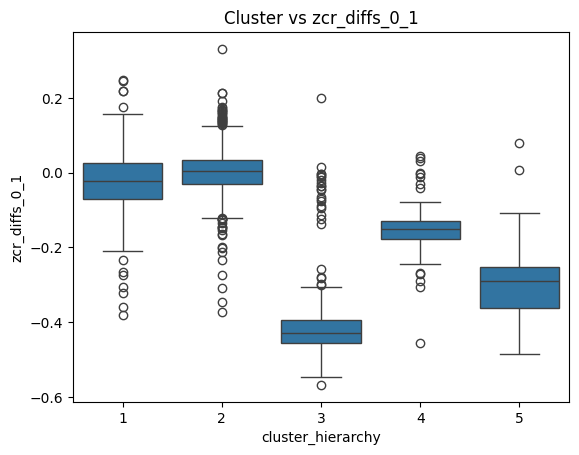

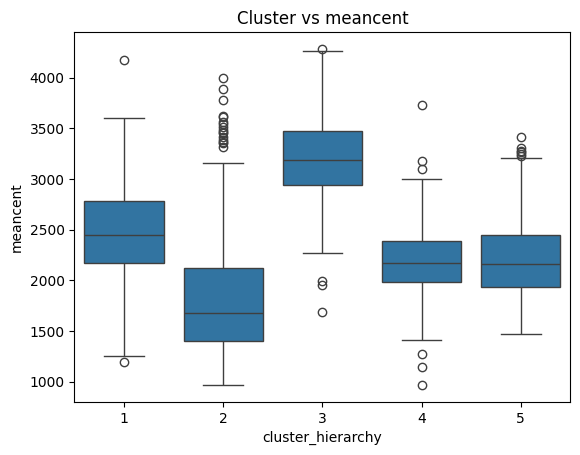

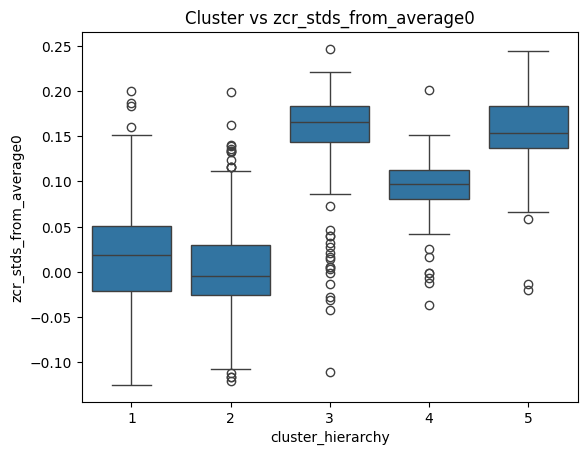

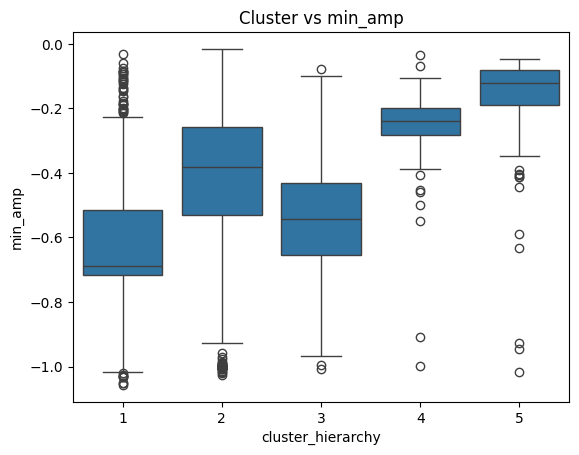

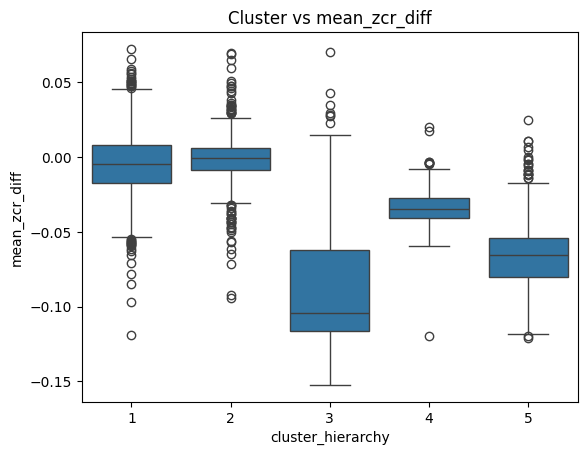

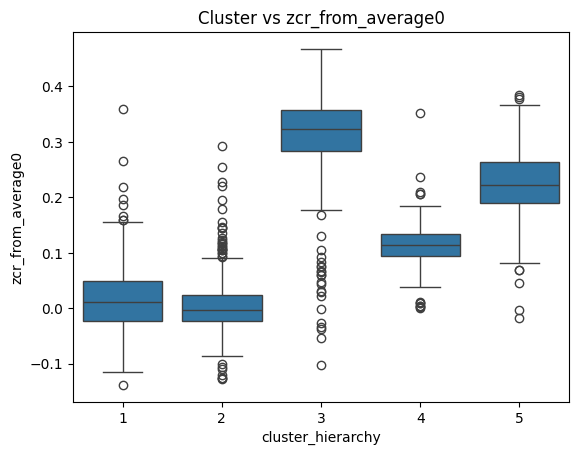

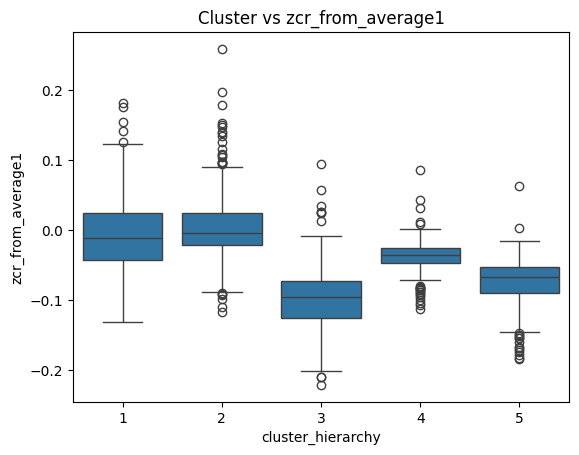

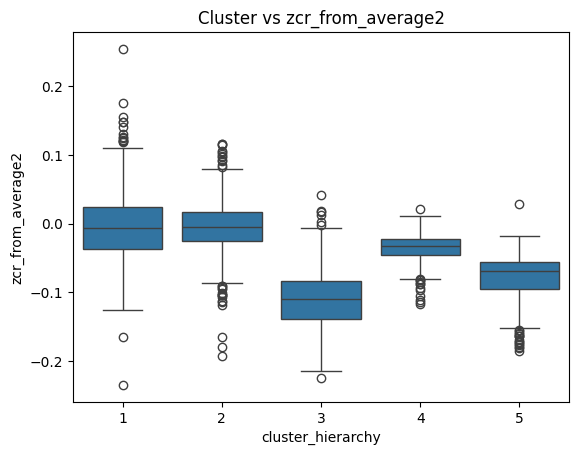

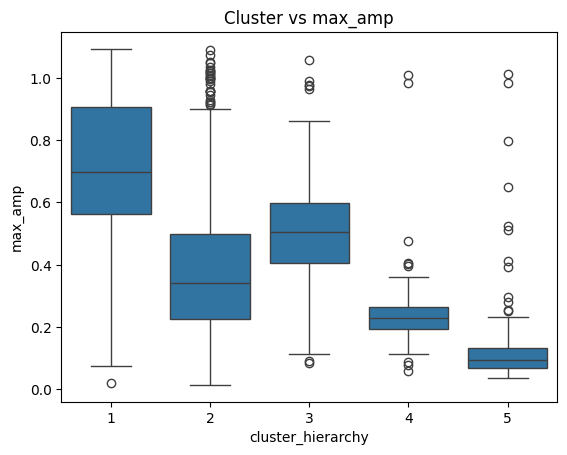

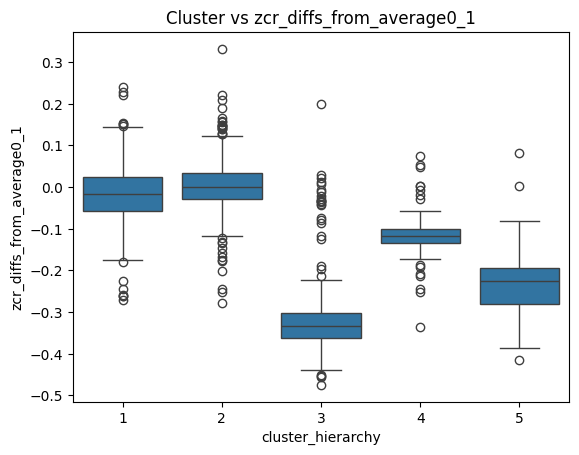

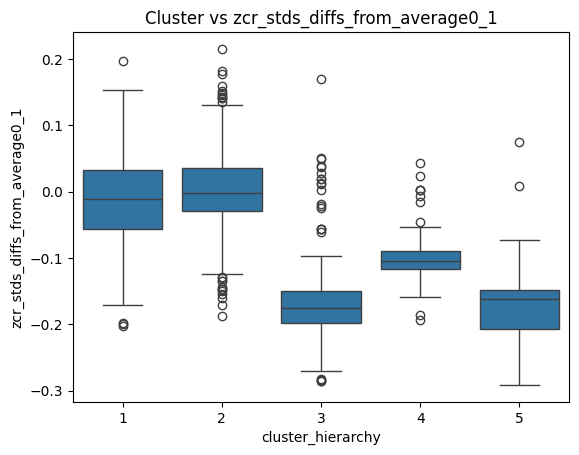

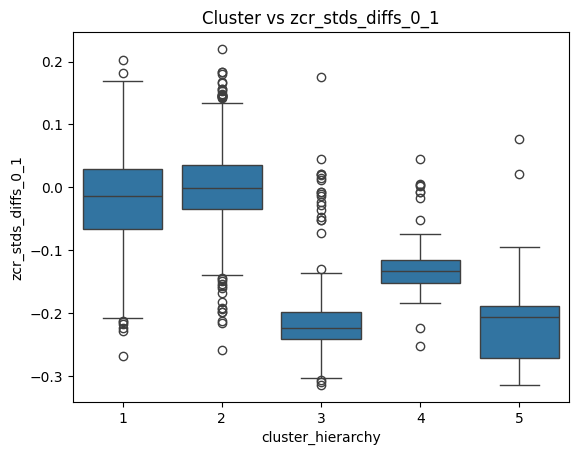

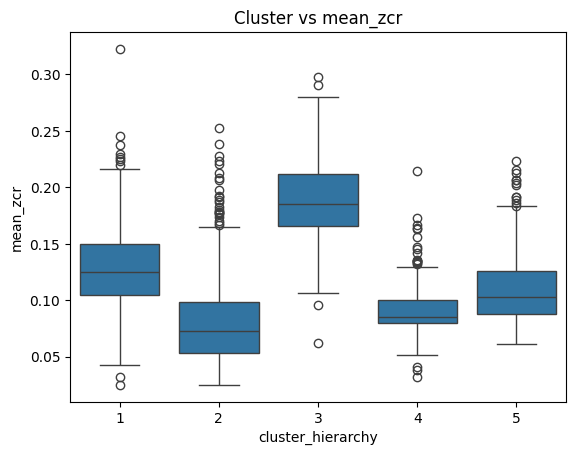

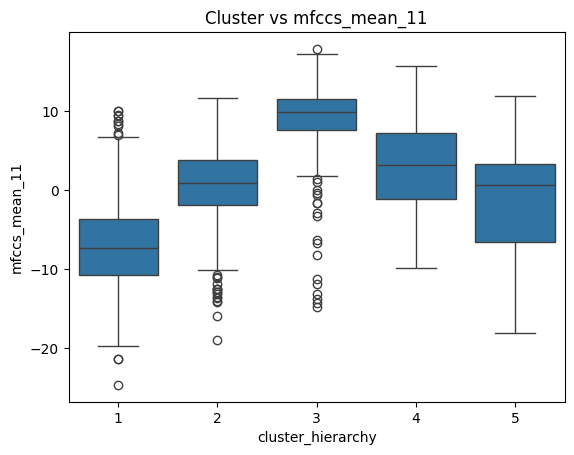

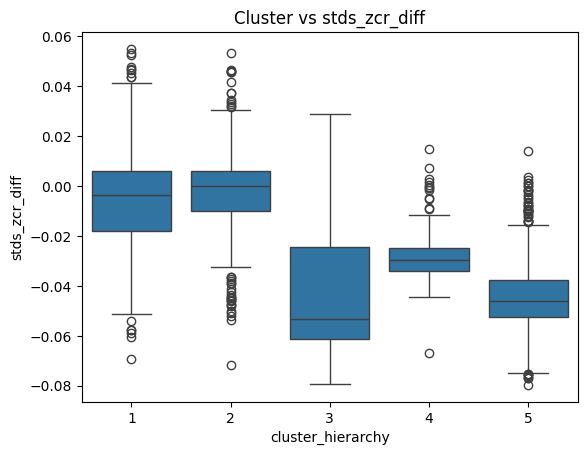

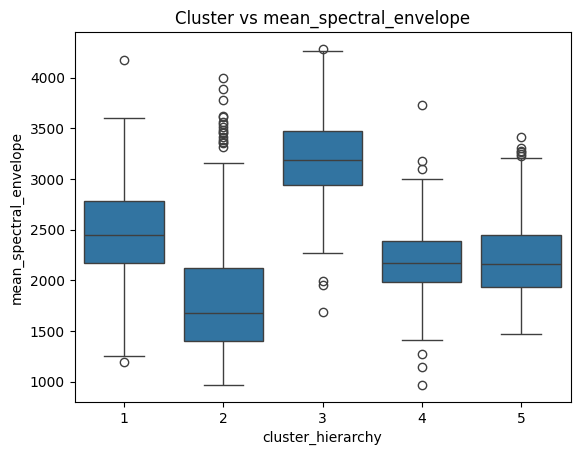

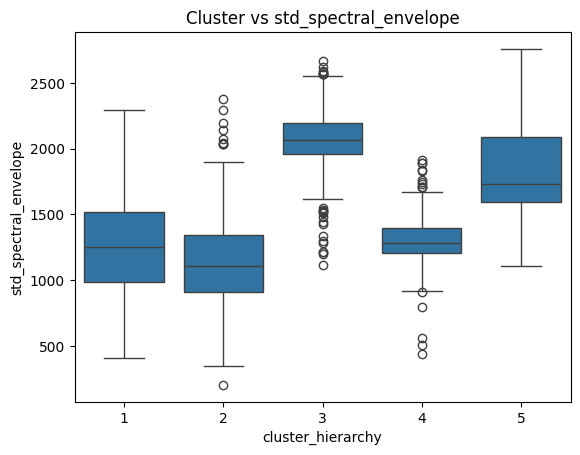

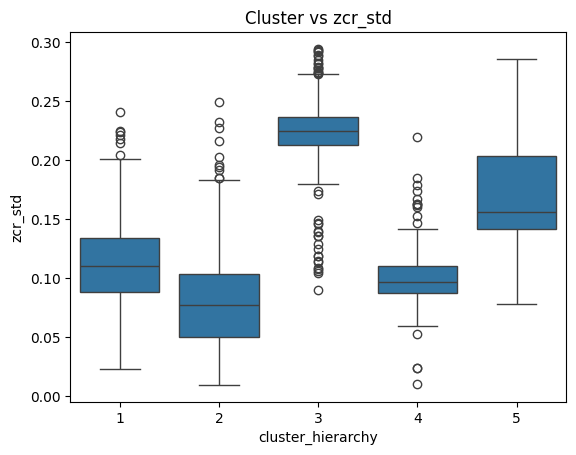

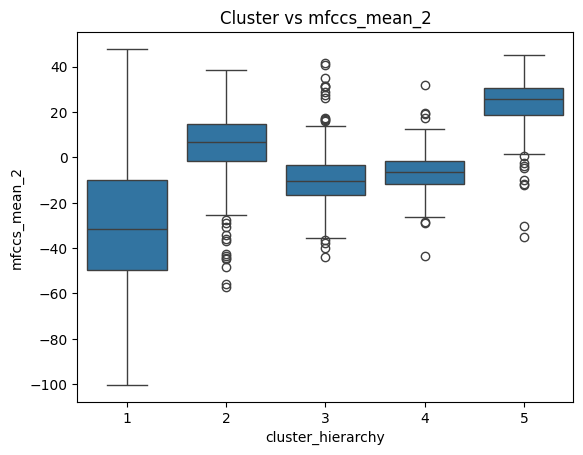

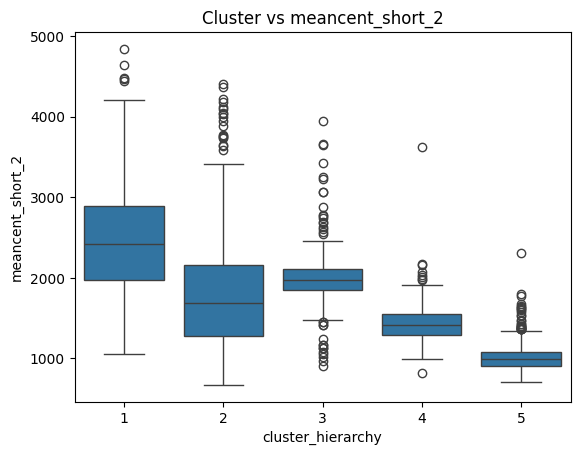

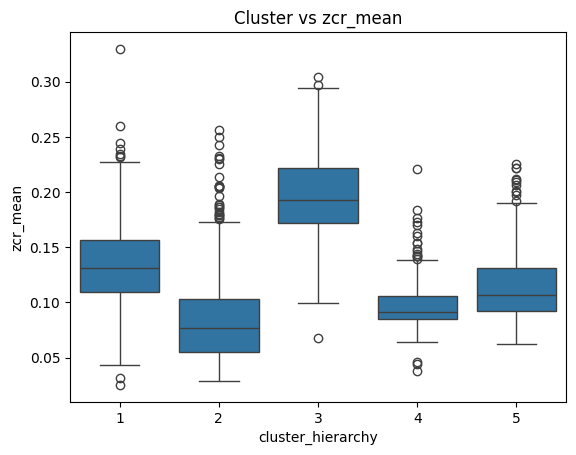

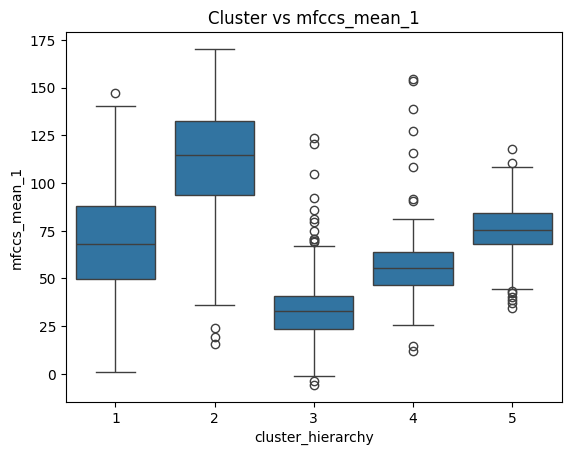

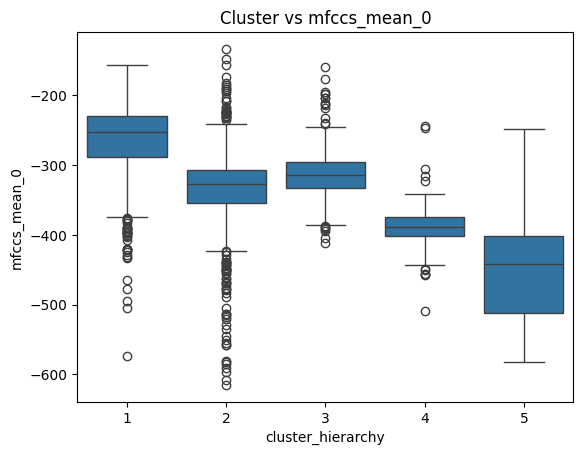

In [44]:
for feature in features:
    sns.boxplot(x='cluster_hierarchy', y=feature, data=train_df)
    plt.title(f'Cluster vs {feature}')
    plt.show()